# RA2CE Feature: Downloading a network for a area of interest based on a hazard map

One of the RA2CE functionalities is extracting road networks from OpenStreetMaps (OSM)* for any place in the world. You can do this, by creating a polygon of the area you would like to extract the road network from.<br> For analyzing hazard events and their impact on the road network you can also set your network extent to match the hazard extent. 

<br>**OSM files are usually neater because they are checked before uploading. These files usually have a good (realistic) connectivity, but still it is required to check the network carefully.*<br>

In this notebook, we will guide you through the basics of RA2CE : Configuring a road network based on your hazard map extent

First of all, we will import the packages we need to execute this notebook:

In [1]:
from pathlib import Path
import geopandas as gpd
import folium 
from shapely.geometry import box
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
from shapely.ops import transform
import pyproj

Next we will call the necessary RA2CE scripts for our code

In [2]:
from ra2ce.network.network_config_data.enums.network_type_enum import NetworkTypeEnum
from ra2ce.network.network_config_data.enums.road_type_enum import RoadTypeEnum
from ra2ce.network.network_config_data.network_config_data import (NetworkConfigData,NetworkSection)
from ra2ce.network.network_wrappers.osm_network_wrapper.osm_network_wrapper import (OsmNetworkWrapper,)
from ra2ce.network.network_simplification.snkit_network_wrapper import (SnkitNetworkWrapper)


## Folder structure

Before starting the examples, it is good if you familiarize yourself with the RA2CE folder structure. RA2CE requires this folder structure to succesfully perform analyses. You can find the folder structure in the **documentation**.
<br>

<pr>A project folder must contain the subfolders 'output' and 'static'. An 'input' folder is optional for additional data sets but we will not use that in our example. It must also contain the network.ini and/or analyses.ini files. Within the subfolder 'static', RA2CE expects three subfolders: hazard, network, and output_graph. See below an example folder structure of “Project A”. This folder structure must be created by the user before running RA2CE.</pr>

You can add the path to your project directory to your RA2CE analysis<br>
The project directory should contain the RA2CE folder setup

In [3]:
# specify the name of the path to the project folder where you created the RA2CE folder setup
root_dir = Path(".//data//get_network_with_hazardmap")
assert root_dir.exists()

## The Hazard


Lets define where our hazard map is located and the visualize the hazard map<br>
<br>
<mark>Hazard maps should be .tif in epsg 4326 projection.</mark> 

In [4]:
hazard_folder = root_dir / "static" / "hazard" # find the hazard folder where you locate your hazard map
hazard_map = list(hazard_folder.glob("*.tif"))

File: max_flood_depth.tif, CRS: EPSG:32736


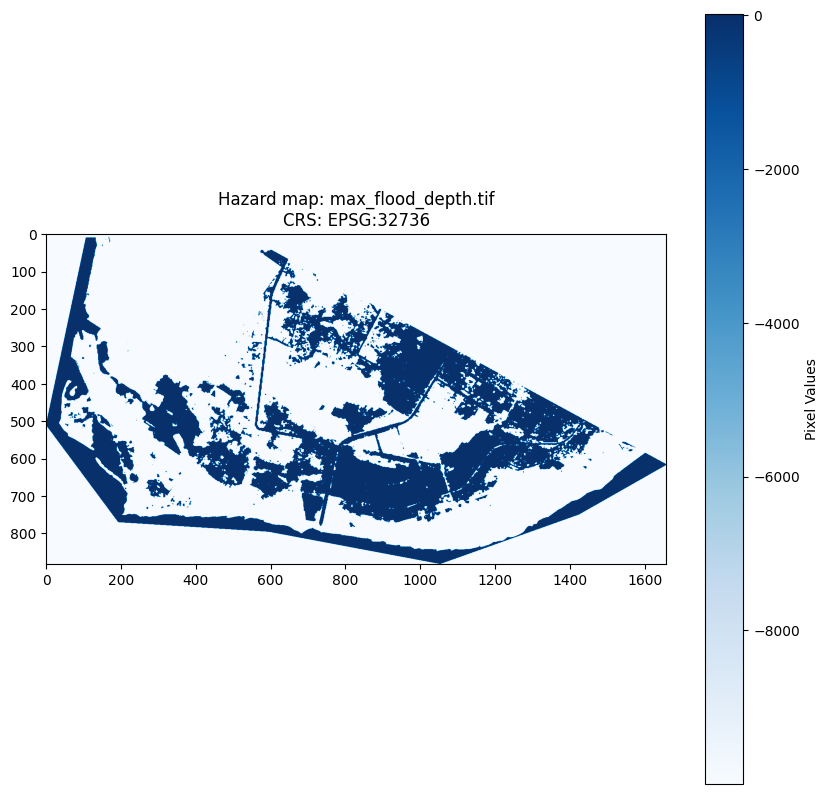

In [5]:
for tif_file in hazard_map:
    with rasterio.open(tif_file) as src:
        tif_array = src.read(1)  # Read the first band
        crs = src.crs  # Get the Coordinate Reference System

    print(f"File: {tif_file.name}, CRS: {crs}")
    
    plt.figure(figsize=(10, 10))
    plt.imshow(tif_array, cmap='Blues')
    plt.colorbar(label='Pixel Values')
    plt.title(f'Hazard map: {tif_file.name}\nCRS: {crs}')
    plt.show()

## Generating the extent of the area

Let's explore the location of the polygon:<br>

*If the hazard map is not in epsg:4326 projection the following code section reprojects the extent to an osm recognized projection

In [6]:
# Function to reproject geometry
def reproject_geometry(geom, src_crs, dst_crs):
    project = pyproj.Transformer.from_crs(src_crs, dst_crs, always_xy=True).transform
    return transform(project, geom)

# Process only the first raster file in the list
with rasterio.open(hazard_map[0]) as src:
    bbox = src.bounds
    bbox_polygon = box(bbox.left, bbox.bottom, bbox.right, bbox.top)  # Create bounding box
    src_crs = src.crs
    dst_crs = 'EPSG:4326'

    if src_crs.to_string() != dst_crs:
        # Reproject the bounding box polygon to EPSG:4326
        bbox_polygon = reproject_geometry(bbox_polygon, src_crs, dst_crs)
        print(f"Hazard Map {hazard_map[0]} is in the CRS: {src_crs}")
        print("Reprojected the polygon to EPSG:4326")

# Create a GeoDataFrame with the bounding box polygon
gdf_polygon = gpd.GeoDataFrame(index=[0], geometry=[bbox_polygon], crs=dst_crs)
centroid = gdf_polygon.geometry.centroid.iloc[0]
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=14)
folium.GeoJson(gdf_polygon).add_to(m)
m


Hazard Map data\get_network_with_hazardmap\static\hazard\max_flood_depth.tif is in the CRS: EPSG:32736
Reprojected the polygon to EPSG:4326


C:\Users\hauth\AppData\Local\Temp\ipykernel_56720\2295356590.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf_polygon.geometry.centroid.iloc[0]


## Set parameters and initalize a RA2CE run


Next we need to define the Network characteristics that needs to be downloaded

First we choose what kind of network that we need for the analysis. In the context of OpenStreetMap (OSM), network types are often used to describe different modes of transportation or access restrictions for routing and mapping purposes. This is handled by the variable network_type in this notebook.
<br>
<br>A network type can be :
<ul>
    <li>NONE : Indicates no specific mode of transportation</li>
    <li>WALK : Refers to pedestrian access. Paths or routes marked with WALK are suitable for walking and may include sidewalks, footpaths, and pedestrian zones</li>
    <li>BIKE : Refers to bicycle access. Routes marked with BIKE are suitable for cycling and may include bike lanes, cycle tracks, and shared-use paths</li>
    <li>DRIVE : Refers to motor vehicle access. This includes cars, trucks, and other motorized vehicles</li>
    <li>DRIVE_SERVICE : Refers to service vehicle access. This is typically used for roads that are intended for use by service vehicles, such as delivery trucks, maintenance vehicles, and emergency services</li>
    <li>ALL : Indicates that all modes of transportation are allowed</li>
    <li>INVALID : Indicates an invalid or undefined mode of transportation</li>
</ul>

Then we can specify the resolution of the selected network by defining road_types.<br>
Road types includes :
<ul>
    <li>NONE: No specific road type
    <li>MOTORWAY:  The highest-performance roads within a territory</li>
    <li>MOTORWAY_LINK: Link roads (sliproads / ramps) leading to and from a motorway. These normally have motorway restrictions</li>
    <li>TRUNK: High-performance or high-importance roads that don't meet the requirements for motorway, but are not classified as primary either (subject to country-specific exceptions)</li>
    <li>TRUNK_LINK: Link roads (sliproads and ramps) leading to and from a trunk</li>
    <li>PRIMARY: Major highway linking large towns, but which does not satisfy the performance requirements of a motorway and does not qualify to be trunk</li>
    <li>PRIMARY_LINK: Slip road/ramp which connects a primary to a secondary, tertiary, or other minor highway</li>
    <li>SECONDARY:  Highways which are not part of major routes, but nevertheless form a link in the national route network</li>
    <li>SECONDARY_LINK: Slip road/ramp which connects a secondary to a tertiary, unclassified or other minor highway</li>
    <li>TERTIARY: Roads connecting smaller settlements, and within large settlements for roads connecting local centres</li> 
    <li>TERTIARY_LINK: Slip road/ramp which connects a tertiary to a tertiary, unclassified or other minor highway</li>
    <li>RESIDENTIAL: Roads that provide access to, or within, residential areas but which are not normally used as through routes</li>
    <li>ROAD: Roads for which the classification is not known</li>
    <li>TUNNEL: Tunnels</li>
    <li>BRIDGE: Bridges</li>
    <li>CULVERT: Culverts</li>
    <li>UNCLASSIFIED: Used for minor public roads, typically at the lowest level of administrative hierarchy in that jurisdiction</li>
    <li>INVALID: Invalid or undefined</li>
</ul>

After that we can start accessing the data from OSM. 
Bare in mind that larger regions and / or the more detail included in the road network may increase download time (significantly)

In [7]:

#First we define which roads we will want to download from OSM to create a network with
network_section = NetworkSection(
    network_type=NetworkTypeEnum.DRIVE, #insert network type
    road_types=[RoadTypeEnum.MOTORWAY,   #Add road types you require
                RoadTypeEnum.MOTORWAY_LINK,
                RoadTypeEnum.TRUNK, 
                RoadTypeEnum.TRUNK_LINK,
                RoadTypeEnum.PRIMARY, 
                RoadTypeEnum.PRIMARY_LINK,
                RoadTypeEnum.SECONDARY,
                RoadTypeEnum.SECONDARY_LINK,
                RoadTypeEnum.TERTIARY,
                RoadTypeEnum.TERTIARY_LINK
                ],
    attributes_to_exclude_in_simplification=['bridge', 'tunnel'],    # add the attributes that needs to be excluded when simplifying the network   
                ) 


#pass the specified sections as arguments for configuration
network_config_data = NetworkConfigData(
    root_path= root_dir,
    output_path= root_dir/"output",
    network=network_section,
    static_path=root_dir.joinpath('static'),
    )

#download the network based on the polygon extent and the specified road characteristics
graph, _ = OsmNetworkWrapper.get_network_from_polygon(network_config_data, bbox_polygon)

c:\Users\hauth\miniforge3\envs\ra2ce_env\lib\site-packages\osmnx\simplification.py:454: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
c:\Users\hauth\miniforge3\envs\ra2ce_env\lib\site-packages\osmnx\simplification.py:501: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid
C:\Users\hauth\repositories\ra2ce\ra2ce\network\network_simplification\nx_to_snkit_network_converter.py:132: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future 

## Explore the results

Get the edges as geopandas

In [8]:
snkit_network_wrapper = SnkitNetworkWrapper.from_networkx(
            graph,
            column_names_dict=dict(
                node_id_column_name="id",
                edge_from_id_column_name="from_id",
                edge_to_id_column_name="to_id",
            ),
        )

edges_gdf = snkit_network_wrapper.snkit_network.edges

Then visualise the edges. 

On the map, you can see the roads you requested from OSM. Use this to check the connectivity and completeness of your network.

In [9]:
# Function to generate random colors, excluding white and light gray
def generate_vivid_colors(n):
    colors = []
    for _ in range(n):
        while True:
            r, g, b = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
            # Exclude colors that are too close to white or light gray
            if (r + g + b) < 600:  # Total brightness threshold (255 * 3 = 765 for white)
                colors.append((r, g, b))
                break
    return colors

# Ensure 'rfid' is treated as categorical and create random distinct RGB colors
edges_gdf['rfid'] = edges_gdf['rfid'].astype('category')
unique_rfid = edges_gdf['rfid'].cat.categories
random_colors = generate_vivid_colors(len(unique_rfid))
random_colors_normalized = [(r/255, g/255, b/255) for r, g, b in random_colors]

# Create a ListedColormap with the random RGB colors
cmap = ListedColormap(random_colors_normalized)

edges_gdf.explore(column='rfid', cmap=cmap, tiles="CartoDB positron", categorical=True, legend=False)